<a href="https://colab.research.google.com/github/zzeeddd95/capstone-project/blob/master/LSTMmsft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**This is a recurrent neural network, specifically an LSTM network designed to predict Microsoft stock prices one day in advance. **


In [ ]:
#import libraries

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import Dropout
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal
Using TensorFlow backend.


In [ ]:
#Get msft stock
msftstock = web.DataReader('MSFT', data_source='yahoo', start='2010-05-27', end='2020-05-27')
msftstock

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-05-27,26.360001,25.730000,25.730000,26.000000,136433600.0,20.539593
2010-05-28,26.120001,25.660000,25.840000,25.799999,67496900.0,20.381601
2010-06-01,26.309999,25.520000,25.530001,25.889999,76152400.0,20.452698
2010-06-02,26.480000,25.730000,26.059999,26.459999,65718800.0,20.902985
2010-06-03,26.930000,26.410000,26.549999,26.860001,67837000.0,21.218981
...,...,...,...,...,...,...
2020-05-20,185.850006,183.940002,184.809998,185.660004,31261300.0,185.660004
2020-05-21,186.669998,183.289993,185.399994,183.429993,29119500.0,183.429993
2020-05-22,184.460007,182.539993,183.190002,183.509995,20826900.0,183.509995


In [ ]:
#Get dataset information
msftstock.shape

(2517, 6)

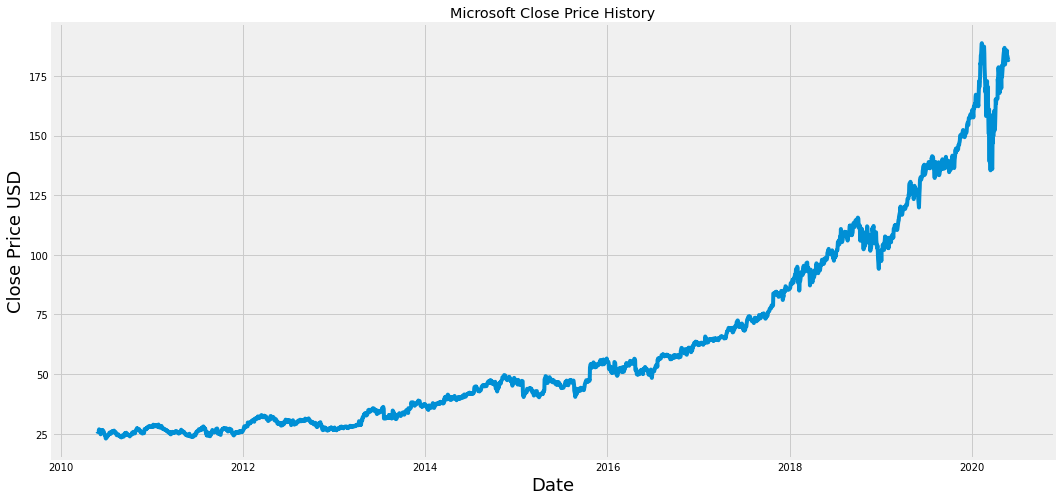

In [ ]:
#visualize closing msft price
plt.figure(figsize=(16,8))
plt.title('Microsoft Close Price History')
plt.plot(msftstock['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.show()

**In this next line of code, we will extract the Microsoft closing price from the stock dataframe, convert it to a numpy array and create a training dataframe consisiting of 80% of closing stock prices.**

In [ ]:
#extract closing price and position into new datafram
msftclose =msftstock.filter(['Close'])
#convert dataframe to numpy array
msftdata = msftclose.values
#obtain row number to train model
training_msft_data = math.ceil(len(msftdata)*.8)
training_msft_data

2014

**Normalizing the data is key to ensuring that the neural network works properly, and so a scale of 0,1 is set, and the following code will enable the normalization of the closing price data. this data will then be inserted into is own variable. **

In [ ]:
#scaling data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_msft_data = scaler.fit_transform(msftdata)
scaled_msft_data

array([[0.01804575],
       [0.01683867],
       [0.01738185],
       ...,
       [0.96867643],
       [0.95696789],
       [0.95841632]])

**In the following lines of code, we will be creating the scaled training data to feed into the neural network from the previous 80% variable that was created. the training data will be from row 0 until the final row, and will include all columns. A loop is created in which the x train set will contain data from positions 0-359 on the first pass, and the y train set will contain data from position 360. the value in position 360 is the value that we require our model to predict. the if loop allows for positions to be filled into the x and y variables with respect to iterations. **

In [ ]:

#create the scaled training dataset

train_msft_data = scaled_msft_data[0:training_msft_data,:]
#split the data omtp x_train and y_train datasets

x_train_msft = []
y_train_msft = []

for i in range(360,len(train_msft_data)):
  x_train_msft.append(train_msft_data[i-360:i,0])
  y_train_msft.append(train_msft_data[i,0])
  if i<= 360:
    print(x_train_msft)
    print(y_train_msft)
    print()

[array([0.01804575, 0.01683867, 0.01738185, 0.02082201, 0.02323617,
       0.01677833, 0.01376064, 0.01267427, 0.01074296, 0.01201038,
       0.01599372, 0.01502806, 0.02154626, 0.01997706, 0.02027884,
       0.02070131, 0.01774398, 0.01665762, 0.01388134, 0.01201038,
       0.00917376, 0.00784597, 0.00181061, 0.        , 0.0009053 ,
       0.0015692 , 0.00488864, 0.00778562, 0.00844951, 0.00760456,
       0.01098437, 0.01279497, 0.01466594, 0.01508842, 0.01134649,
       0.01339851, 0.01490735, 0.01273463, 0.01708009, 0.01689902,
       0.01864929, 0.0190114 , 0.01774398, 0.01822681, 0.01689902,
       0.02003742, 0.0190114 , 0.0164162 , 0.01424347, 0.01532983,
       0.01569196, 0.01243285, 0.01116543, 0.00893234, 0.00838916,
       0.0089927 , 0.01026012, 0.01092401, 0.00863058, 0.00736314,
       0.00766492, 0.00621643, 0.00657855, 0.00488864, 0.00555254,
       0.00380228, 0.00277626, 0.00537147, 0.00561289, 0.00772527,
       0.00573359, 0.00555254, 0.00603537, 0.00506971, 0.0126

**The following two cells of code will allow for increased pre processing of the above created variables to allow for training of the model. it is important to reshape the x train data set becase the lstm networks expects the input to be three dimensional (# of samples, # of timesteps, #of features), however the train data set in its current form is two dimensional. **

In [ ]:
#convert the x_train_msft and y_train_msft to numpy array in order to allow the training of lstm model
x_train_msft,y_train_msft=np.array(x_train_msft), np.array(y_train_msft)

In [ ]:
#Reshape the data in order to obtain three dimensional data to feed into LSTM
x_train_msft=np.reshape(x_train_msft,(x_train_msft.shape[0],x_train_msft.shape[1],1))
x_train_msft.shape

(1654, 360, 1)

**The following cell includes the LSTM model build, and here is where the neural network hyperparamaters can be tuned to achieve the specific output required. The error for the model is tested using the RMSE. This particular model contains 2 LSTM layers with 200 neurons each, 2 dense layers (allowing for output of predictions from the neuron layers), a model compiler and a model fitter. **

In [10]:
#Build the LSTM model for msft
model = Sequential()
model.add(LSTM(200,return_sequences=True, input_shape=(x_train_msft.shape[1],1)))
model.add(LSTM(200, return_sequences=False))
model.add(Dense(100))
model.add(Dense(1))
#compile the msft model
model.compile(optimizer='adam',loss='mean_squared_error')
#train the model
model.fit(x_train_msft,y_train_msft, batch_size=2,epochs=7)

Epoch 1/7
1654/1654 [==============================] - 760s 460ms/step - loss: 3.1122e-04
Epoch 2/7
1654/1654 [==============================] - 758s 458ms/step - loss: 2.2877e-04
Epoch 3/7
1654/1654 [==============================] - 794s 480ms/step - loss: 1.0865e-04
Epoch 4/7
1654/1654 [==============================] - 781s 472ms/step - loss: 1.5826e-04
Epoch 5/7
1654/1654 [==============================] - 772s 467ms/step - loss: 9.9688e-05
Epoch 6/7
1654/1654 [==============================] - 750s 454ms/step - loss: 1.0871e-04
Epoch 7/7
1654/1654 [==============================] - 772s 467ms/step - loss: 7.4435e-05


In [11]:
#create the testing data set by creating a new array containg scaled values from index 1924 - 2517
test_msft_data = scaled_msft_data[training_msft_data - 360: , :]
#create the datasets x_msft_test and y_msft_test
x_msft_test = []
y_msft_test = msftdata[training_msft_data:, :]
for i in range(360,len(test_msft_data)):
  x_msft_test.append(test_msft_data[i-360:i, 0])

In [12]:
#convert data into numpy array
x_msft_test=np.array(x_msft_test)

In [13]:
#Reshape test data
x_msft_test = np.reshape(x_msft_test,(x_msft_test.shape[0],x_msft_test.shape[1],1))

In [14]:
#obtain model predicted price values, we want prediction to obtain same values as y_msft_test dataset
msftpredictions = model.predict(x_msft_test)
msftpredictions=scaler.inverse_transform(msftpredictions)

In [15]:
#Evaluate the model by getting the RMSE
rmse = np.sqrt( np.mean( msftpredictions-y_msft_test)**2)
rmse

4.1141600864782015

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


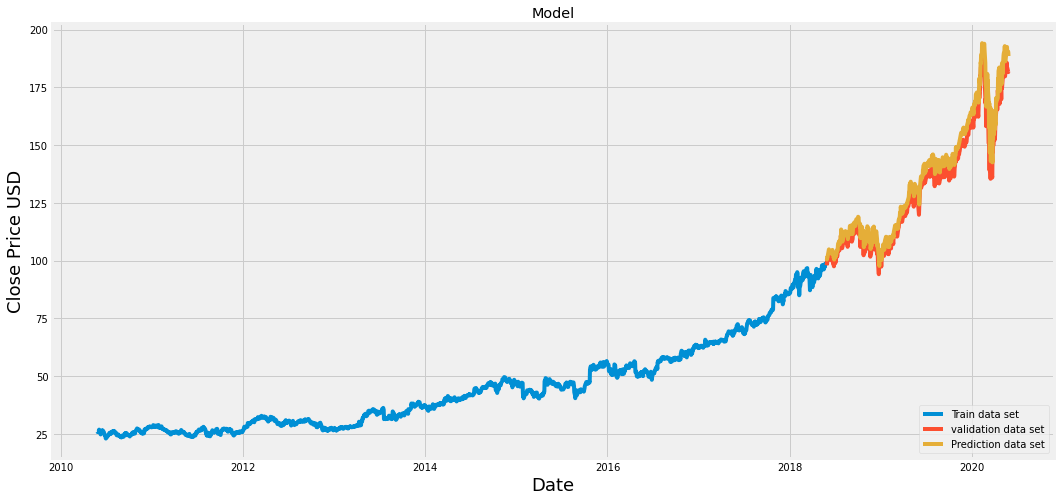

In [16]:
#Plot data
train = msftclose[:training_msft_data]
valid = msftclose[training_msft_data:]
valid['Predictions'] = msftpredictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train data set', 'validation data set','Prediction data set'],loc ='lower right' )
plt.show()

In [17]:
#show the validation price and predicted price
valid

,Close,Predictions
Date,,
2018-05-29,98.010002,100.804886
2018-05-30,98.949997,100.465866
2018-05-31,98.839996,101.405525
2018-06-01,100.790001,101.342133
2018-06-04,101.669998,103.251244
...,...,...
2020-05-20,185.660004,190.522232
2020-05-21,183.429993,192.471558
2020-05-22,183.509995,190.227371


In [18]:
#Predict future price
msft_quote = web.DataReader('MSFT', data_source='yahoo', start='2010-05-27', end='2020-06-30')
#Create new dataframe
new_df = msft_quote.filter(['Close'])
#Extract last 360 days closing price and convert df to array
last_360_days = new_df[-360:].values
#scalre the data to be valued between 0 and 1
last_360_days_scaled = scaler.transform(last_360_days)
#create an empty list
X_test = []
#Append past 360 days to empty list
X_test.append(last_360_days_scaled)
#Convert the X_test dataset to a numpy array
X_test = np.array(X_test)
#Reshape data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
#Get the predicted scaled price
pred_price = model.predict(X_test)
#Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[210.68652]]


In [19]:
msft_quote2 = web.DataReader('MSFT', data_source='yahoo', start='2010-05-27', end='2020-07-01')
print(msft_quote2['Close'])


Date
2010-05-27     26.000000
2010-05-28     25.799999
2010-06-01     25.889999
2010-06-02     26.459999
2010-06-03     26.860001
                 ...    
2020-06-25    200.339996
2020-06-26    196.330002
2020-06-29    198.440002
2020-06-30    203.509995
2020-07-01    204.699997
Name: Close, Length: 2542, dtype: float64
